# ReLORETA code

In [12]:
import numpy as np
from numpy import linalg as LA
from scipy.linalg import pinv

class ReLORETA():
  ##################### This version has been updated on 19/10/2025   ##########################
  # lambda1: ReLORETA regularisation parameter
  # epsilon:  the threshold to stop eLORETA. It is usually set to a high value to let max_iter stop the algorithm.
  # max_iter: The maximum number of iteration
  # W: The block diagonal weight matrix of size k*k, obtained from the eLORETA function
  # K: The lead field matrix of size m*k
  # X: The input EEG matrix of size m*n
  # m: the number of electrodes
  # k: number of voxels (dipoles or source points) set by user
  # n_source: number of voxels (dipoles or source points) set by user
  # dimension: Leadfield matrix dimension
  # n: number of EEG samples in the X matrix
  # lambda2: eLORETA regularisation parameter
  # n_source: number of source points
  # lr: ReLORETA Learning rate  (19/10/2025)

  def __init__(self,lambda2 = 0.05, dimension=3,n_source=82, epsilon=1e-29, max_iter=100,lambda1=1,lr=1e8): # alpha could be 0.1
    self.max_iter=max_iter
    self.lambda2=lambda2
    self.dimension=dimension
    self.n_source=n_source
    self.epsilon=epsilon
    self.lambda1=lambda1
    self.lr=lr
    self.y=[]
    self.W=[]
    self.K=[]
    self.er=[]
  @property
  def get(self):
      return self.max_iter, self.lambda2, self.dimension, self.n_source, self.epsilon, self.lambda1
  @get.setter
  def set(self, values):
    self.max_iter, self.lambda2, self.dimension, self.n_source, self.epsilon, self.lambda1=values

  def eloreta_source_localization(self,eeg_data, leadfield, noise_cov):
      """
      Perform source localization using the eLORETA method.

      Parameters:
          eeg_data (numpy.ndarray): EEG data matrix (channels x time points)
          leadfield (numpy.ndarray): Lead field matrix (channels x sources)
          noise_cov (numpy.ndarray): Noise covariance matrix (channels x channels)

      Returns:
          numpy.ndarray: Source activity matrix (sources x time points)
      """
      # # Regularization parameter (small value to stabilize inversion)    ################################ Bottleneck: if lambda2 is given as the input argument, then don't set it here (19/10/2025).
      # lambda2 = 0.05
      lambda2 = self.lambda2

      # Step 1: Whitening the data using noise covariance matrix
      whitener = pinv(np.sqrt(noise_cov))
      whitened_eeg = np.dot(whitener, eeg_data)
      whitened_leadfield = np.dot(whitener, leadfield)

      # Step 2: Compute the source covariance matrix
      leadfield_t = whitened_leadfield.T
      source_cov = np.dot(leadfield_t, whitened_leadfield) + lambda2 * np.eye(leadfield.shape[1])

      # Step 3: Compute the eLORETA inverse operator
      inverse_operator = np.dot(np.linalg.pinv(source_cov), leadfield_t)

      # Step 4: Compute source activity
      source_activity = np.dot(inverse_operator, whitened_eeg)

      return source_activity
  def fit(self, X,K,source_points=[],real_source=[]):
    # real_source: The real source coordinates. A list of three elements, x,y, and z
    # source_points: The dipoles (source points) coordinates. For example, if the source has 30 points,
    # source_points will be a list including 30 points' coordinates. Each point's coordinates should be a list with 3 elements, i. e. x,y, and z
    epsilon=self.epsilon
    max_iter=self.max_iter
    lambda1=self.lambda1
    lr=self.lr
    X=np.array(X)
    K_all=[]
    X_rel_all=[]
    pow_all=[]
    source_points=np.array(source_points)
    real_source=np.array(real_source)

    K_all.append(K)

    # y=np.array(y)
    k=K.shape[1]
    n=X.shape[1]
    m=K.shape[0]
    R=np.identity(m)
    flag=0
    I=np.identity(m)
    lambda1=lambda1
    iter=0
    k_stop=0 # number of times the objective function can not improve
    E=[]
    y_rel_all=[]
    noise_cov = np.identity(m)
    y = self.eloreta_source_localization(X, K, noise_cov)
    self.y=y.copy()
    self.power()
    pow_all.append(self.pow)
    y_rel_all.append(y)
    # Calculating objective function before the update
    X_rel=K.dot(y)
    X_rel_all.append(X_rel)
    Ei=(LA.norm(X-X_rel,ord='fro'))**2   # The original objective function
    # Ei=(LA.norm(X-X_rel,ord='fro'))       # Bottleneck: You can use this Ei for simplicity. The original function is Ei^2 (the code above)
    E.append(Ei)
    print("Iteration {}\n".format(iter))
    print("ReLORETA error {}\n".format(abs(E[0])))
    if real_source.shape[0]!=0:
      self.localisation_error(source_points, real_source)
      le=self.error
      print("Localisation error {}\n".format(le))


    while flag==0:
      iter=iter+1
      print("Iteration {}\n".format(iter))
      #Calculating D
      t1=R.dot(K).dot(y)  #### Bottleneck: here we can also use K_new. In this case you need to set K_new=K.copy() before starting the while loop
      t2=t1-X
      t3=np.transpose(K.dot(y))  #### Bottleneck: check X. It shoul be updated each iteration
      D=2*t2.dot(t3)
      #Updating R
      t4=np.linalg.inv(I+(lambda1*I))
      R=R-lr*t4.dot(D)    ### Bottleneck: lr could be removed
      #Updating leadfield matrix
      K_new=R.dot(K)
      self.K=K_new.copy()
      K_all.append(K_new)
      # Calculating objective function after the update
      noise_cov = np.identity(m)
      y = self.eloreta_source_localization(X, K_new, noise_cov)
      self.y=y.copy()
      self.power()
      pow_all.append(self.pow)
      #####################
      # self.fit(K_new,X,dimension,n_source)
      # y=self.y.copy()
      #####################
      y_rel_all.append(y)
      X_rel=K_new.dot(y)
      X_rel_all.append(X_rel)
      ###############
      Ei=(LA.norm(X-X_rel,ord='fro'))**2   # The original objective function
      # Ei=Ei/m      # Not a part of the objective function. Just for testing.
      ###############
      # Ei=(LA.norm(X-X_rel,ord='fro'))       # For testing. Uncomment the above code if you want the original activation function. You may need to adjust lr then.
      ###############
      E.append(Ei)
      print("ReLORETA error {}\n".format(abs(E[iter])))
      if real_source.shape[0]!=0:
        self.localisation_error(source_points, real_source)
        le=self.error
        print("Localisation error {}\n".format(le))
      # Levenberg-Marquardt
      if abs(E[iter]-E[iter-1])<epsilon:
        k_stop=k_stop+1

      if k_stop >= 1:
        print("Minimum error achieved")
        flag=1
      elif iter >= max_iter:
        print("Maximum iterations exceeded")
        flag=1
      else:
        if E[iter]-E[iter-1]<=0:
          lambda1=lambda1*0.1
        else:
          lambda1=lambda1*10

    self.E=E.copy()
    self.y=y.copy()
    self.y_rel=y.copy()
    self.K_rel=K_new.copy()
    self.y_rel_all=y_rel_all.copy()
    self.X_rel=X_rel.copy()
    self.X_rel_all=X_rel_all.copy()
    self.K_all=K_all.copy()
    self.pow_all=pow_all.copy()
  #Calculating the source power
  def power(self):
    dim=self.dimension
    n_source=self.n_source
    y=self.y.copy()
    y=np.array(y)
    pow=[]
    if dim==1:
      for i in range(y.shape[0]):
        pow.append(np.mean(y[i,:]**2))
    else:
      for i in range(n_source):
        yy=y[i*3:i*3+3,:]
        yy=np.sum(yy**2,axis=0)
        pow.append(np.mean(yy))
    self.pow=np.array(pow).copy()
  # Localising the source
  def localise(self,source_points):
    #source_points is n_source*3
    source_points=list(source_points)
    self.power()
    pow=self.pow.copy()
    source=source_points[np.argmax(pow)]
    self.source=source.copy()
  # Calculating the localisation error
  def localisation_error(self,source_points, real_source):
    real_source=list(real_source)
    self.localise(source_points)
    source=self.source.copy()
    error=LA.norm(source-real_source,ord=2)
    self.error=error.copy()

def plot_numpy_array(array, title='Numpy Array Plot'):
    """
    Plot a 1D numpy array.

    Parameters:
        array (numpy.ndarray): 1D array to plot.
        title (str): Title of the plot.
    """

    plt.plot(array)
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Example usage

Installing dependencies

In [2]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.7 MB/s eta 0:00:00


In [3]:
import mne
import numpy as np
import scipy as sc
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
import mne
from scipy.linalg import pinv

mne.datasets.fetch_fsaverage(subjects_dir=str(mne.datasets.sample.data_path()) + '/subjects')

Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 2.47TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 02m00s (1576.2 MB)
16 files missing from root.txt in /root/mne_data/MNE-sample-data/subjects


100%|████████████████████████████████████████| 196M/196M [00:00<00:00, 272GB/s]


Extracting missing files
Successfully extracted 16 files
10 files missing from bem.txt in /root/mne_data/MNE-sample-data/subjects/fsaverage


100%|████████████████████████████████████████| 239M/239M [00:00<00:00, 350GB/s]


Extracting missing files
Successfully extracted 10 files


PosixPath('/root/mne_data/MNE-sample-data/subjects/fsaverage')

Calculating Leadfield matrix

In [ ]:
import mne
import numpy as np
from mne import make_bem_model, make_bem_solution, make_forward_solution
import os
from mne.transforms import apply_trans
# Load the sample dataset for head model and transformation
data_path = mne.datasets.sample.data_path()
data_path=str(data_path)
subjects_dir = data_path + '/subjects'
subject = 'sample'
trans_fname = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'

###### Define the custom source points (convert from mm to meters)
source_points = np.array([
    [41, -27, 47], [-40, -27, 47], [38, -18, 45], [-36, -19, 48], [15, -33, 48],
    [-14, -33, 48], [28, -1, 51], [-28, -2, 52], [23, -60, 61], [-18, -61, 55],
    [22, 26, 45], [-23, 24, 44], [35, 39, 31], [-39, 34, 37], [23, 55, 7],
    [-23, 55, 4], [12, 37, -19], [-11, 38, -19], [44, 4, 0], [-42, 4, -1],
    [11, -78, 9], [-11, -81, 7], [29, -92, 2], [-19, -92, 2], [44, -75, 5],
    [-45, -75, 11], [48, -17, -31], [-47, -14, -34], [60, -27, -9], [-59, -25, -13],
    [54, -19, 1], [-57, -20, 1], [9, -45, 24], [-10, -45, 24], [5, 5, 31],
    [-5, 1, 32], [7, 17, -14], [-5, 17, -13], [12, -45, 8], [-12, -43, 8],
    [8, -48, 39], [-8, -49, 38], [6, 33, 16], [-5, 39, 20], [31, 3, -15],
    [-28, 3, -17], [26, -19, -25], [-26, -20, -22], [47, -51, -14], [-47, -52, -12],
    [40, 11, -30], [-43, 13, -30], [46, -59, 31], [-46, -60, 33], [51, -33, 34],
    [-53, -32, 33], [50, -21, 7], [-52, -19, 7], [49, 12, 17], [-48, 13, 17],
    [46, 26, 7], [-47, 27, 6], [43, 38, 12], [-46, 38, 8], [38, 30, -12],
    [-40, 31, -13], [14, 13, 11], [-11, 13, 10], [25, 3, -1], [-26, 3, -1],
    [10, -19, 6], [-9, -17, 6], [19, 0, -2], [-20, 0, -2], [10, 10, -12],
    [-11, 9, -11], [21, -1, -22], [-24, 0, -21], [28, -22, -14], [-29, -19, -15],
    [3, -1, -11], [-4, -2, -11]
]) / 1000  # Convert from mm to meters

##### Select your channels here
selected_channels = ['Fp1', 'AF3', 'AF7', 'Fz', 'F1', 'F3', 'F5', 'F7', 'FC1', 'FC3', 'FC5', 'FT7', 'Cz',
                     'C1', 'C3', 'C5', 'T7', 'CP1', 'CP3', 'CP5', 'TP7', 'TP9', 'Pz', 'P1', 'P3', 'P5',
                     'P7', 'PO3', 'PO7', 'Oz', 'O1', 'Fpz', 'Fp2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8',
                     'FC2', 'FC4', 'FC6', 'FT8', 'C2', 'C4', 'C6', 'T8', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8',
                     'TP10', 'P2', 'P4', 'P6', 'P8', 'POz', 'PO4', 'PO8', 'O2']

subjects_dir = str(mne.datasets.sample.data_path()) + '/subjects'
os.environ['SUBJECTS_DIR'] = subjects_dir

trans = mne.read_talxfm(subject='fsaverage', subjects_dir=subjects_dir)

# Step 2: Apply the transformation to convert MNI coordinates to MRI surface RAS coordinates
source_points = apply_trans(trans['trans'], source_points) # convert source points from MNI to MRI surface RAS coordinates which is used by MNE


# Step 2: Create a source space for the fsaverage subject (which is in MNI space)
# Set up a source space with the fsaverage subject (a standard template)



# source_space = mne.setup_source_space('fsaverage', spacing='oct6', subjects_dir=subjects_dir, add_dist=False)


#################################### Use this to spread source over volume

source_space = mne.setup_volume_source_space(subject='fsaverage', pos=15, subjects_dir=subjects_dir)

####################################

# Create an empty volume source space, and use custom source points instead
# source_space = mne.setup_volume_source_space(subject=subject, pos=15, subjects_dir=subjects_dir)

# Replace the source points in the source space with the provided custom source points
source_space[0]['rr'] = source_points
source_space[0]['nn'] = np.zeros_like(source_points)  # Dummy normals, can set as zeros
source_space[0]['nuse'] = len(source_points)
source_space[0]['inuse'] = np.ones(len(source_points), dtype=int)

# ########################## This part should only be used with setup_source_space not  setup_volume_source_space
# source_space[1]['rr'] = source_points
# source_space[1]['nn'] = np.zeros_like(source_points)  # Dummy normals, can set as zeros
# source_space[1]['nuse'] = len(source_points)
# source_space[1]['inuse'] = np.ones(len(source_points), dtype=int)
# #####################################



# Load the precomputed BEM model
# bem_model = make_bem_model(subject=subject, ico=2, subjects_dir=subjects_dir)
# bem = make_bem_solution(bem_model)
model = mne.make_bem_model(subject='fsaverage', ico=2, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)
# Select 10 specific electrodes from the 10-20 system (you can choose any 10)
# For example: ['Fp1', 'Fp2', 'F7', 'F8', 'T3', 'T4', 'C3', 'C4', 'O1', 'O2']

# Use the montage (10-20 system) and create info with the selected channels
montage = mne.channels.make_standard_montage('standard_1005')
raw_info = mne.create_info(ch_names=selected_channels, sfreq=1000, ch_types='eeg')
raw_info.set_montage(montage)

# Create the forward solution using 10 EEG electrodes and the custom source points with 3D orientations
fwd = make_forward_solution(info=raw_info, trans=trans_fname, src=source_space, bem=bem, eeg=True, meg=False)

# Extract the lead field matrix (gain matrix)
lead_field = fwd['sol']['data']
print("Lead field matrix shape (3D):", lead_field.shape)

# For the first source point, extract the x, y, z components
first_source_contributions = lead_field[:, :3]
print("First source point contributions (shape):", first_source_contributions.shape)

# Optionally save the lead field matrix for further analysis
np.savetxt("lead_field_3d.csv", lead_field, delimiter=",")

Importing the data (find it on my Github page)

In [5]:
## Example 1: Data 1
from scipy.io import loadmat
# Replace 'your_file.mat' with your MATLAB file path
data = loadmat('/content/data1.mat')    #### EEG data (evoked potential similar to seizure)
loc=loadmat('/content/loc1.mat')        #### Location of the brain source, for example array([[30, 60, 10]], dtype=uint8)
data1=data['datat1']
loc1=loc['loc1']

In [34]:
## Example 2: Data 2
from scipy.io import loadmat
# Replace 'your_file.mat' with your MATLAB file path
data = loadmat('/content/data2.mat')    #### EEG data (evoked potential similar to seizure)
loc=loadmat('/content/loc2.mat')        #### Location of the brain source, for example array([[30, 60, 10]], dtype=uint8)
data1=data['datat2']
loc1=loc['loc2']

Running ReLORETA

In [ ]:
model1=ReLORETA()
model1.lr=1e3      ## You need to adjust this until you get a smooth declining curve for Ei that shows the convergence of the algorithm
model1.max_iter=250
model1.fit(data1,lead_field,source_points,loc1)

Visualisation

' \nNOTE: If the reconstructed signal matches the original signal, it means that the ReLORETA algorithm is working well.\nNOTE: If the eLORETA algorithm reconstructs the signal well, then the ReLORETA reconstructed signal will not be significantly different from \neLORETA reconstructed signal. This often happens when the number of source points is few, for example less than 200 or 300, which is the case in this example. \n\n'

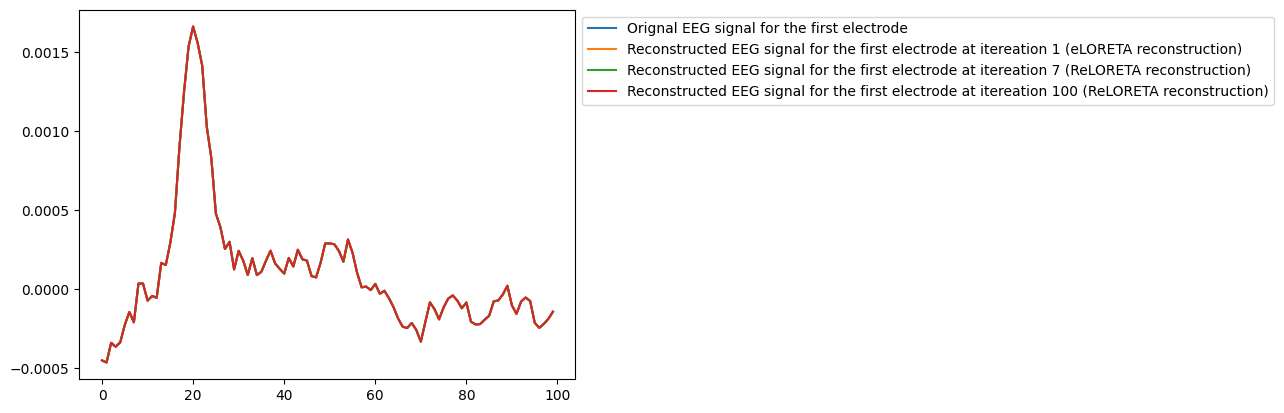

In [44]:
import matplotlib.pyplot as plt
plt.plot(data1[0,:],label='Orignal EEG signal for the first electrode')
plt.plot(model1.X_rel_all[0][0,:], label='Reconstructed EEG signal for the first electrode at itereation 1 (eLORETA reconstruction)')
plt.plot(model1.X_rel_all[2][0,:], label='Reconstructed EEG signal for the first electrode at itereation 7 (ReLORETA reconstruction)')
plt.plot(model1.X_rel_all[100][0,:], label='Reconstructed EEG signal for the first electrode at itereation 100 (ReLORETA reconstruction)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

"""
NOTE: If the reconstructed signal matches the original signal, it means that the ReLORETA algorithm is working well.
NOTE: If the eLORETA algorithm reconstructs the signal well, then ReLORETA reconstructed signal will not be significantly different from
eLORETA reconstructed signal. This often happens when the number of source points is few, for example less than 200 or 300, which is the case in this example.

"""

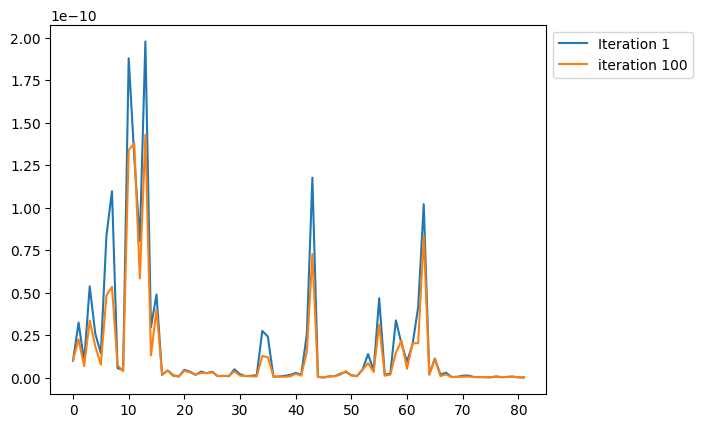

In [45]:
# Visualising the source power
import matplotlib.pyplot as plt
plt.plot(model1.pow_all[0],label='Iteration 1')   ## Visualising the power
plt.plot(model1.pow_all[100],label='iteration 100')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

Convergence plot (objective function value for all iterations)

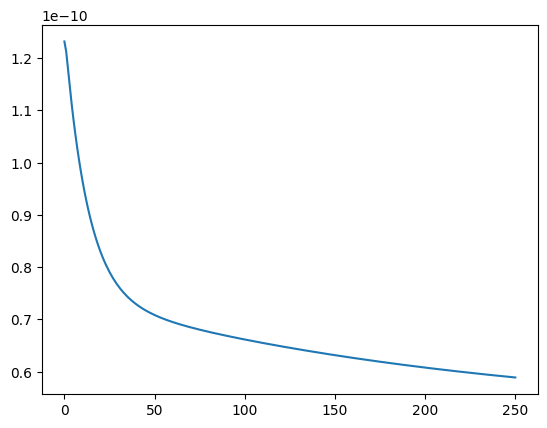

In [46]:
import matplotlib.pyplot as plt
plt.plot(model1.E)

# The plot should have a smooth converging shape. If it doesn't, you need to adjust lr to make the algorithm converge

Localised source (for localisation problems)

In [47]:
source_index_ReLORETA=int(np.argmax(model1.pow_all[100]))
source_index_eLORETA=int(np.argmax(model1.pow_all[0]))

In [53]:
Localised_source_location_RELORETA=source_points[source_index_ReLORETA]
Localised_source_location_eLORETA=source_points[source_index_eLORETA]
print("Localised source location ReLORETA: {}".format(Localised_source_location_RELORETA*1000))
print("Localised source location eLORETA: {}".format(Localised_source_location_eLORETA*1000))
print("The real source location: {}".format(loc1[0]))

# """
# If the source points don’t have high resolution, the localisation accuracy will naturally be lower. This occurs because there are no source points
# near the true source location for the algorithm to identify it accurately. As a result, ReLORETA localisation will not differ significantly
# from eLORETA when the source space resolution is low, which typically happens when the number of source points is few.
# Use more than 300 source points (preferably 500) to see the difference
# """

Localised source location ReLORETA: [-39.  34.  37.]
Localised source location eLORETA: [-39.  34.  37.]
The real source location: [-10  60  20]


Reconstructed source signal (for classification problems)

In [51]:
source_signal=model1.y

In [52]:
source_signal.shape   # (82*3) * 100

(246, 100)